In [5]:
!pip install --upgrade mxnet==1.6.0

In [6]:
!pip install gluonts

In [7]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
mpl.rcParams["figure.figsize"]=(10,8)
mpl.rcParams['axes.grid']=False

In [8]:
df=pd.read_csv("mydata.csv",index_col=0,parse_dates=True)

In [9]:
df

,y,y1,y2,y3,y4,y5
ds,,,,,,
2015-01-01,31.43,124104,2333163,416332,24434,2650.0
2016-01-01,30.93,140840,2398644,464542,42510,3948.0
2017-01-01,31.10,159395,2435509,507946,47949,5154.0
2018-01-01,32.34,179358,2784477,557410,50204,5213.2
2019-01-01,33.48,209848,2905319,608401,56887,5545.2
2020-01-01,34.28,231378,2759173,640968,57910,7303.8


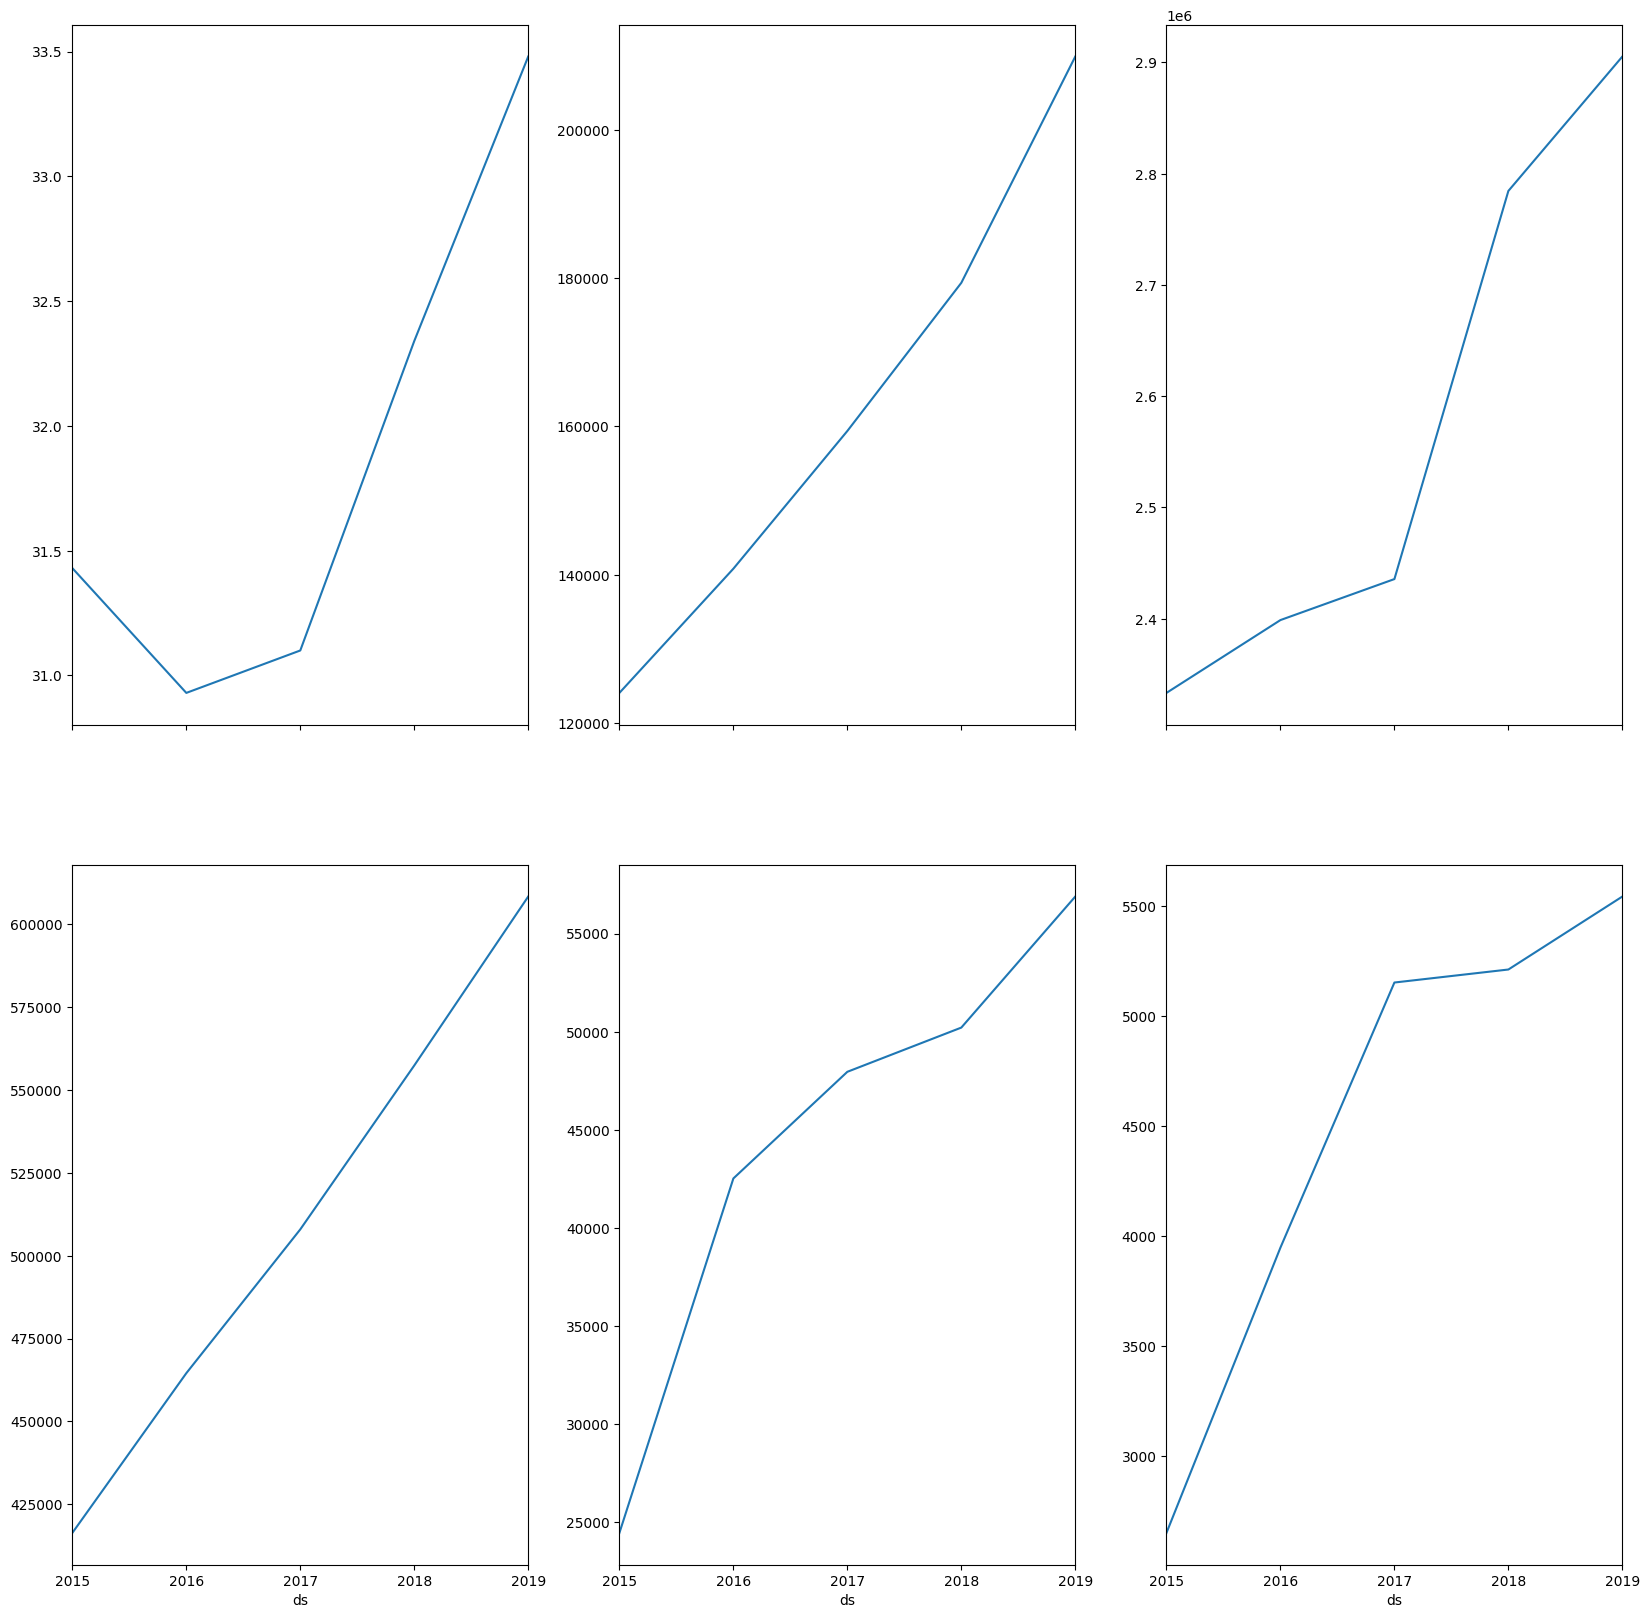

In [10]:
fig,axs=plt.subplots(2,3,figsize=(20,20),sharex=True)
axx=axs.ravel()
for i in range(0,6):
    df[df.columns[i]].loc["2015-01-01":"2019-01-01"].plot(ax=axx[i])
    axx[i].set_xlabel("ds")
    axx[i].set_ylabel("")
    axx[i].grid(which='minor',axis='x')

In [11]:
df_input=df.reset_index(drop=True).T.reset_index()

In [12]:
df_input

,index,0,1,2,3,4,5
0,y,31.43,30.93,31.1,32.34,33.48,34.28
1,y1,124104.00,140840.00,159395.0,179358.00,209848.00,231378.00
2,y2,2333163.00,2398644.00,2435509.0,2784477.00,2905319.00,2759173.00
3,y3,416332.00,464542.00,507946.0,557410.00,608401.00,640968.00
4,y4,24434.00,42510.00,47949.0,50204.00,56887.00,57910.00
5,y5,2650.00,3948.00,5154.0,5213.20,5545.20,7303.80


In [13]:
ts_code=df_input["index"].astype('category').cat.codes.values

In [14]:
ts_code

array([0, 1, 2, 3, 4, 5], dtype=int8)

In [15]:
df_train=df_input.iloc[:,1:6].values
df_test=df_input.iloc[:,6:].values

In [16]:
df_train.shape

(6, 5)

In [17]:
df_test.shape

(6, 1)

In [18]:
freq="1y"
start_train=pd.Timestamp("2015-1-1",freq=freq)
start_test=pd.Timestamp("2019-1-1",freq=freq)
prediction_length=2

<ipython-input-18-ccd0f1ecf46c>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train=pd.Timestamp("2015-1-1",freq=freq)
<ipython-input-18-ccd0f1ecf46c>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test=pd.Timestamp("2019-1-1",freq=freq)


In [19]:
estimator=DeepAREstimator(freq="1y",
                         context_length=4,
                          prediction_length=prediction_length,
                          use_feat_static_cat=True,
                          cardinality=[1],
                          num_layers=1,
                          num_cells=8,
                          cell_type='lstm',
                          trainer=Trainer(epochs=8))

In [20]:
df_train

array([[3.143000e+01, 3.093000e+01, 3.110000e+01, 3.234000e+01,
        3.348000e+01],
       [1.241040e+05, 1.408400e+05, 1.593950e+05, 1.793580e+05,
        2.098480e+05],
       [2.333163e+06, 2.398644e+06, 2.435509e+06, 2.784477e+06,
        2.905319e+06],
       [4.163320e+05, 4.645420e+05, 5.079460e+05, 5.574100e+05,
        6.084010e+05],
       [2.443400e+04, 4.251000e+04, 4.794900e+04, 5.020400e+04,
        5.688700e+04],
       [2.650000e+03, 3.948000e+03, 5.154000e+03, 5.213200e+03,
        5.545200e+03]])

In [21]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [22]:
train_ds=ListDataset([
    {
        FieldName.TARGET:target,
        FieldName.START:start_train,
        FieldName.FEAT_STATIC_CAT:fsc

    }
    for (target,fsc) in zip(df_train[0:7],
                            ts_code[0:7].reshape(-1,1))
],freq=freq)

In [23]:
test_ds=ListDataset([
    {
        FieldName.TARGET:target,
        FieldName.START:start_train,
        FieldName.FEAT_STATIC_CAT:fsc

    }
    for (target,fsc) in zip(df_train[0:7],
                            ts_code[0:7].reshape(-1,1))
],freq=freq)

In [24]:
next(iter(train_ds))

{'target': array([31.43, 30.93, 31.1 , 32.34, 33.48], dtype=float32),
 'start': Period('2015', 'A-DEC'),
 'feat_static_cat': array([0], dtype=int32)}

In [25]:
predictor=estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:00<00:00, 73.27it/s, epoch=8/8, avg_epoch_loss=11.1]


In [26]:
from gluonts.evaluation.backtest import make_evaluation_predictions


In [27]:
forecast_it, ts_it=make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=1,
)

In [28]:
from tqdm.autonotebook import tqdm
print("obtaining time series conditioning values....")
tss=list(tqdm(ts_it,total=len(df_test)))
print("Obtaining time series predictions...")
forecasts=list(tqdm(forecast_it,total=len(df_test)))

obtaining time series conditioning values....


<ipython-input-28-9d740ae46d8c>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/6 [00:00<?, ?it/s]

Obtaining time series predictions...


  0%|          | 0/6 [00:00<?, ?it/s]

In [29]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[33.297844, 33.06234 ]], dtype=float32), start_date=Period('2018', 'A-DEC')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[207017.08, 171749.  ]], dtype=float32), start_date=Period('2018', 'A-DEC')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[2832602., 4094406.]], dtype=float32), start_date=Period('2018', 'A-DEC')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[781283.2 , 558653.06]], dtype=float32), start_date=Period('2018', 'A-DEC')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[55741.137, 59634.19 ]], dtype=float32), start_date=Period('2018', 'A-DEC')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[5817.221, 5866.344]], dtype=float32), start_date=Period('2018', 'A-DEC'))]

In [34]:
tss

[          0
 2015  31.43
 2016  30.93
 2017  31.10
 2018  32.34
 2019  33.48,
              0
 2015  124104.0
 2016  140840.0
 2017  159395.0
 2018  179358.0
 2019  209848.0,
               0
 2015  2333163.0
 2016  2398644.0
 2017  2435509.0
 2018  2784477.0
 2019  2905319.0,
              0
 2015  416332.0
 2016  464542.0
 2017  507946.0
 2018  557410.0
 2019  608401.0,
             0
 2015  24434.0
 2016  42510.0
 2017  47949.0
 2018  50204.0
 2019  56887.0,
                 0
 2015  2650.000000
 2016  3948.000000
 2017  5154.000000
 2018  5213.200195
 2019  5545.200195]

In [31]:
from gluonts.evaluation import Evaluator
evaluator=Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics,item_metrics=evaluator(iter(tss),iter(forecasts),num_series=len(df_test[0:7]))

Running evaluation: 100%|██████████| 6/6 [00:00<00:00, 140.21it/s]


In [32]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2018,5.459522e-01,1.375504e+00,6.582000e+01,3.291000e+01,0.335,2.052990,0.021046,0.020869,0.0,0.020898,82.119605,1.807651e+00,0.5,1.375504e+00,0.5,0.943356,0.5
1,None,2018,1.108279e+09,6.575808e+04,3.892060e+05,1.946030e+05,17645.500,1.863310,0.167883,0.171427,0.0,0.168954,74.532402,5.740614e+04,0.5,6.575808e+04,0.5,74110.015625,0.5
2,None,2018,7.081220e+11,1.237212e+06,5.689796e+06,2.844898e+06,51173.000,12.088523,0.213281,0.178444,0.0,0.217444,483.540930,2.226982e+06,1.0,1.237212e+06,1.0,247442.400000,1.0
3,None,2018,2.629703e+10,2.736211e+05,1.165811e+06,5.829055e+05,45807.000,2.986674,0.241700,0.209860,0.0,0.234705,119.466959,4.129213e+05,0.5,2.736211e+05,0.5,134320.925000,0.5
4,None,2018,1.910347e+07,8.284328e+03,1.070910e+05,5.354550e+04,11757.500,0.352300,0.079292,0.075841,0.0,0.077358,14.091989,1.491179e+04,1.0,8.284328e+03,1.0,1656.865625,1.0
5,None,2018,2.339874e+05,9.251650e+02,1.075840e+04,5.379200e+03,1252.000,0.369475,0.086889,0.082902,0.0,0.085995,14.778994,1.665297e+03,1.0,9.251650e+02,1.0,185.033008,1.0
